In [1]:
import pandas as pd

#math/stats imports
import numpy as np
np.random.seed(42)

from scipy.stats import norm, pearsonr, pointbiserialr, ttest_ind

#viz imports
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm

import seaborn as sns

#modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


import warnings
warnings.filterwarnings('ignore')

import itertools

# Wisconsin Breast Cancer Analysis
Data from Kaggle: https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data/data

In [2]:
df = pd.read_csv('./Data/data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [4]:
df.drop(columns = ['Unnamed: 32'], inplace = True)

df['diagnosis'] = df['diagnosis'].map({'B': 0
                                      , 'M': 1
                                      })

In [5]:
len(df.columns)

32

**Note:** 32 features (not including 'id', 'diagnosis') to observe

In [6]:
mean_columns = ['radius_mean', 'texture_mean', 'perimeter_mean'
                , 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean'
                , 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']

se_columns = ['radius_se', 'texture_se', 'perimeter_se', 'area_se'
              , 'smoothness_se', 'compactness_se', 'concavity_se'
              , 'concave points_se', 'symmetry_se', 'fractal_dimension_se']

worst_columns = ['radius_worst', 'texture_worst', 'perimeter_worst'
                 , 'area_worst', 'smoothness_worst', 'compactness_worst'
                 , 'concavity_worst', 'concave points_worst', 'symmetry_worst'
                 , 'fractal_dimension_worst']

## EDA

### Observing the Distribution of Features:
Examining the distribution of features:
- Overall
- When 'diagnosis' is Benign
- When 'diagnosis' is Malignant

In [7]:
def create_histogram_ax(dataframe, column, ax, title = True):
    """
    Creates a single plot with a histogram and a faint boxplot overlay for a specified column in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column (str): The column name for which to create the visualizations.
    ax (matplotlib.axes.Axes): The Axes object to draw the plot onto.
    """
    # Extract the data for the specified column
    data = dataframe[column]

    # Create the histogram
    sns.histplot(data, kde=True, alpha=0.7, ax=ax)

    # Calculate median and quartiles for the boxplot overlay
    median = data.median()
    mean = data.mean()

    # Add vertical lines for mean and median
    ax.axvline(mean, color='orange', linestyle='--', label=f'Mean ({mean:.2f})', alpha=0.7)
    ax.axvline(median, color='orange', linestyle='-', label=f'Median ({median:.2f})', alpha=0.7)

    # ax.set_title(column, fontsize=8)
        
    ax.set_xlabel(xlabel=column, fontsize=8)
    ax.set_ylabel(ylabel='Count', fontsize=8)

    # Set tick label sizes
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

    # Add legend
    ax.legend(fontsize=8)

    return

In [8]:
def create_subplot_grid(dataframe, columns, plot_function, suptitle='Histograms:'):
    sns.set_style("darkgrid")
    
    num_cols = 3
    num_rows = -(-len(columns) // num_cols)
    
    subplot_height = 3
    subplot_width = 4
    
    fig_height = subplot_height * num_rows
    fig_width = subplot_width * num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))
    
    axes = axes.flatten()
    
    for i, (ax, column) in enumerate(zip(axes, columns)):
        if i < len(columns):
            # Call the plot function without the 'title' parameter
            plot_function(dataframe, column, ax)
        else:
            ax.axis('off')

    for ax in axes[len(columns):]:
        ax.remove()

    plt.suptitle(f'{suptitle}', y=1.01)
    plt.tight_layout()
    
    # Close the figure to prevent automatic display
    plt.close(fig)
    
    return fig

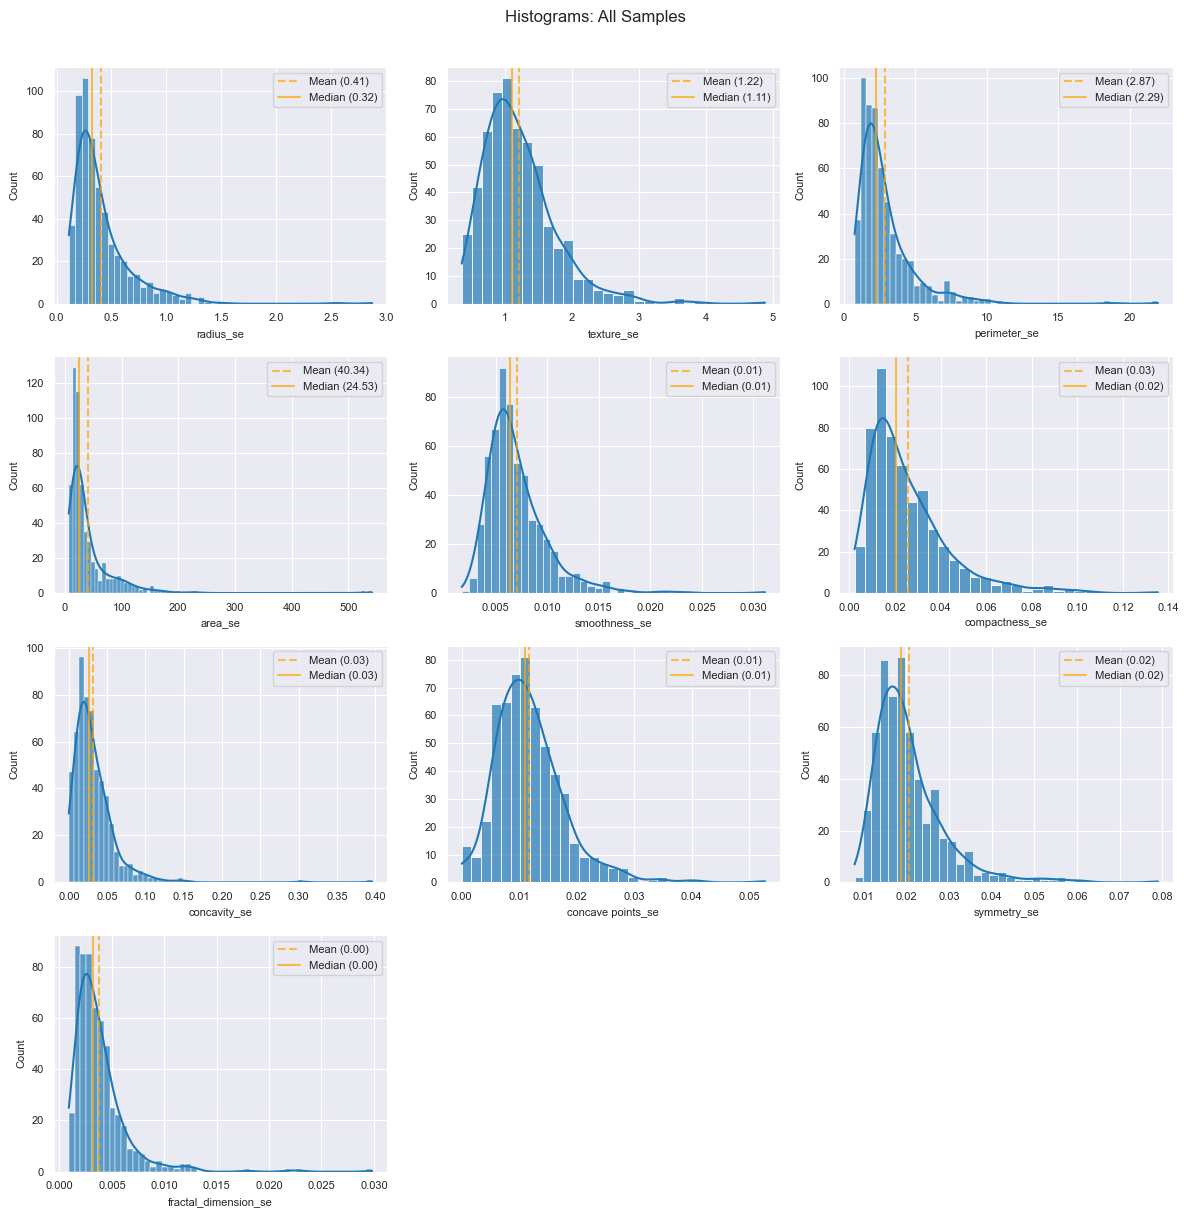

In [9]:
all = create_subplot_grid(df, se_columns, create_histogram_ax, suptitle = 'Histograms: All Samples')
all

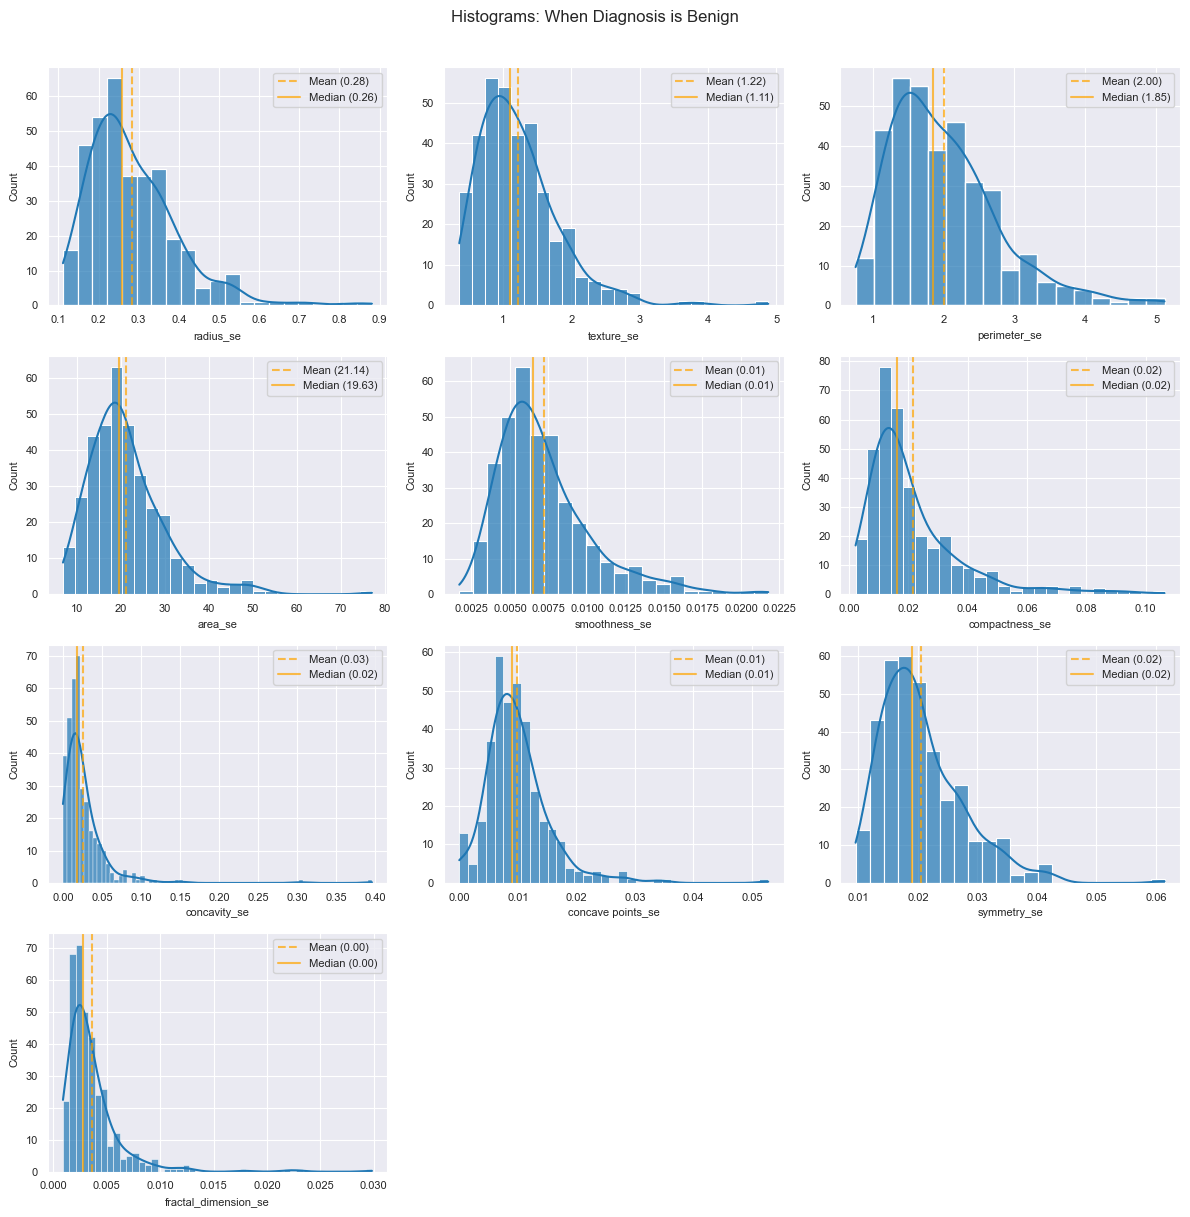

In [10]:
create_subplot_grid(df[df['diagnosis'] == 0], se_columns, create_histogram_ax, suptitle = 'Histograms: When Diagnosis is Benign')

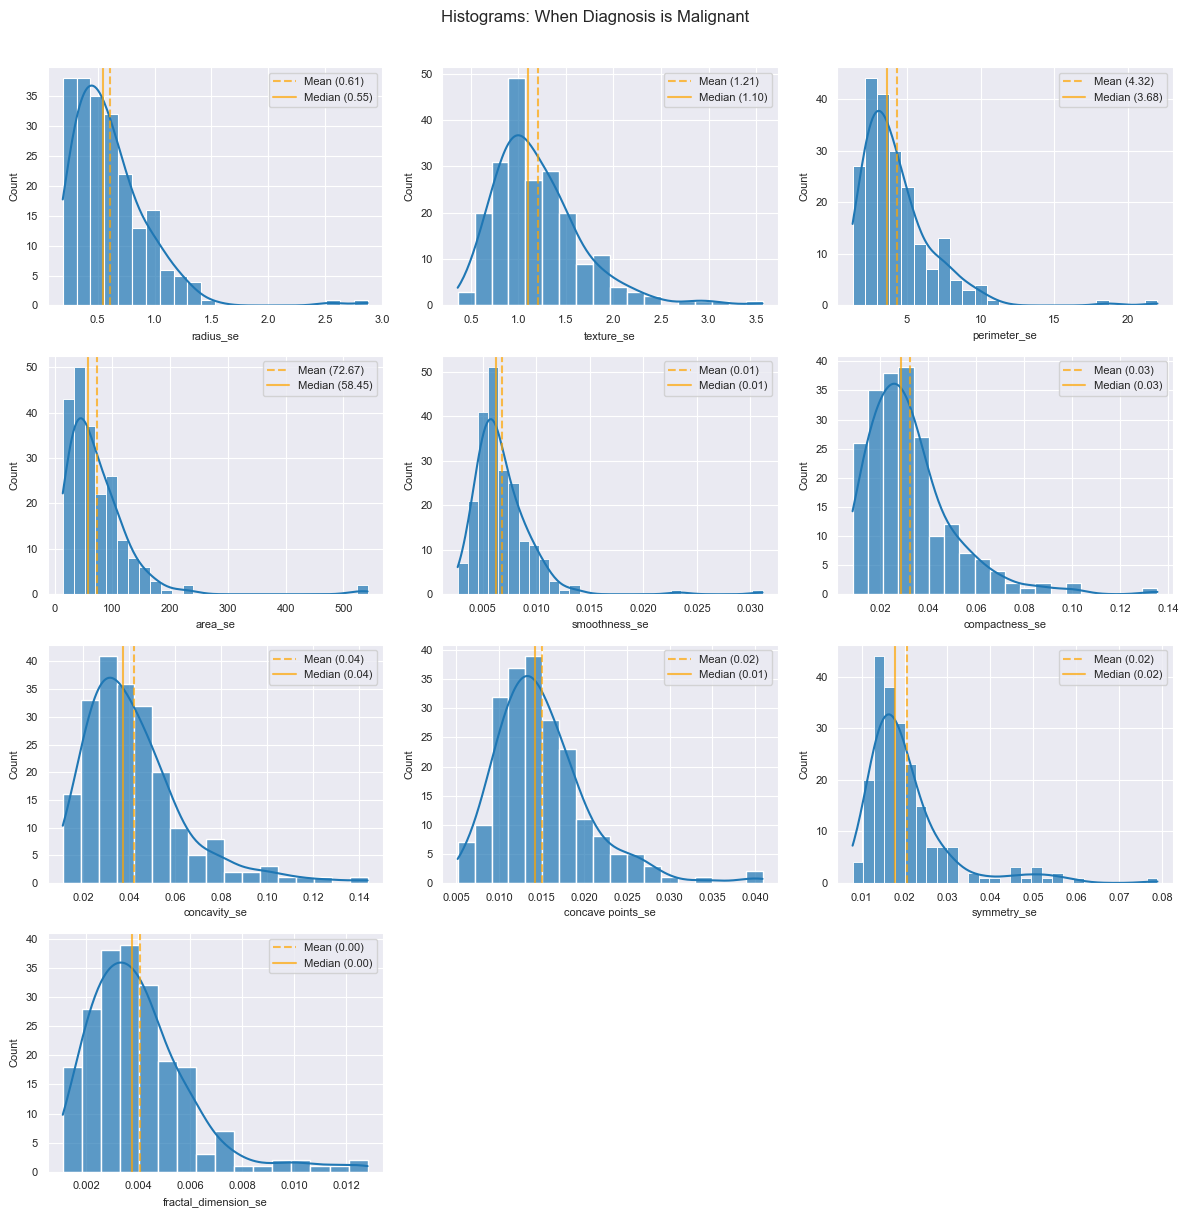

In [11]:
create_subplot_grid(df[df['diagnosis'] == 1], se_columns, create_histogram_ax, suptitle = 'Histograms: When Diagnosis is Malignant')

### Hypothesis Tests:
Using Correlation and T-Tests to highlight the features with significant relationships and their differences with respect to 'diagnosis'

#### Correlation
- Pearson Correlation for relationships between features
- Point Biserial Correlation for relationships between features and binary outcome

In [12]:
def calculate_pearson_and_significance(df, columns, significance_threshold=0.05):
    """
    Calculates Pearson correlation coefficients and creates a binary column indicating significance.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing numeric columns.
    significance_threshold (float): The significance threshold for correlation coefficients (default is 0.05).
    
    Returns:
    pd.DataFrame: Binary DataFrame indicating significance of correlation coefficients.
    pd.DataFrame: Correlation matrix.
    """
    # Calculate Pearson correlation coefficients and p-values
    correlation_matrix = df[columns].corr(method=lambda x, y: pearsonr(x, y)[0])
    p_values = df[columns].corr(method=lambda x, y: pearsonr(x, y)[1])

    # Create a binary column indicating significance
    is_significant = p_values < significance_threshold

    # Convert boolean values to 0/1
    binary_df = is_significant.astype(int)
    
    return binary_df, correlation_matrix

binary_df, corr_matrix = calculate_pearson_and_significance(df, columns = mean_columns)

In [13]:
def visualize_correlation_heatmap(corr_matrix, binary_df):
    """
    Visualizes correlation coefficients using a heatmap with masked insignificant cells.
    
    Parameters:
    corr_matrix (pd.DataFrame): Correlation matrix.
    binary_df (pd.DataFrame): Binary DataFrame indicating significance of correlation coefficients.
    """
    sns.set_style("white")

    # Create mask to remove non-significant (0 binary) values and upper triangular mask
    mask = np.triu(binary_df.values, k=1)  # Mask upper triangle (excluding diagonal)
    mask |= (binary_df.values == 0)  # Mask non-significant (0 binary) values
    
    # Set up the heatmap
    plt.figure(figsize=(12, 10))
    
    # Customize the heatmap
    sns.heatmap(corr_matrix
                ,mask = mask
                ,vmin = -1
                ,vmax = 1
                ,cmap = 'coolwarm'
                ,annot = True
                ,annot_kws = {'fontsize': 10}
                ,fmt = ".2f"
                ,square = True
                ,linewidths = .5)

    # Add title
    plt.title('Correlation Heatmap with Masked Insignificant Cells')

    # Show plot
    plt.show()

    return

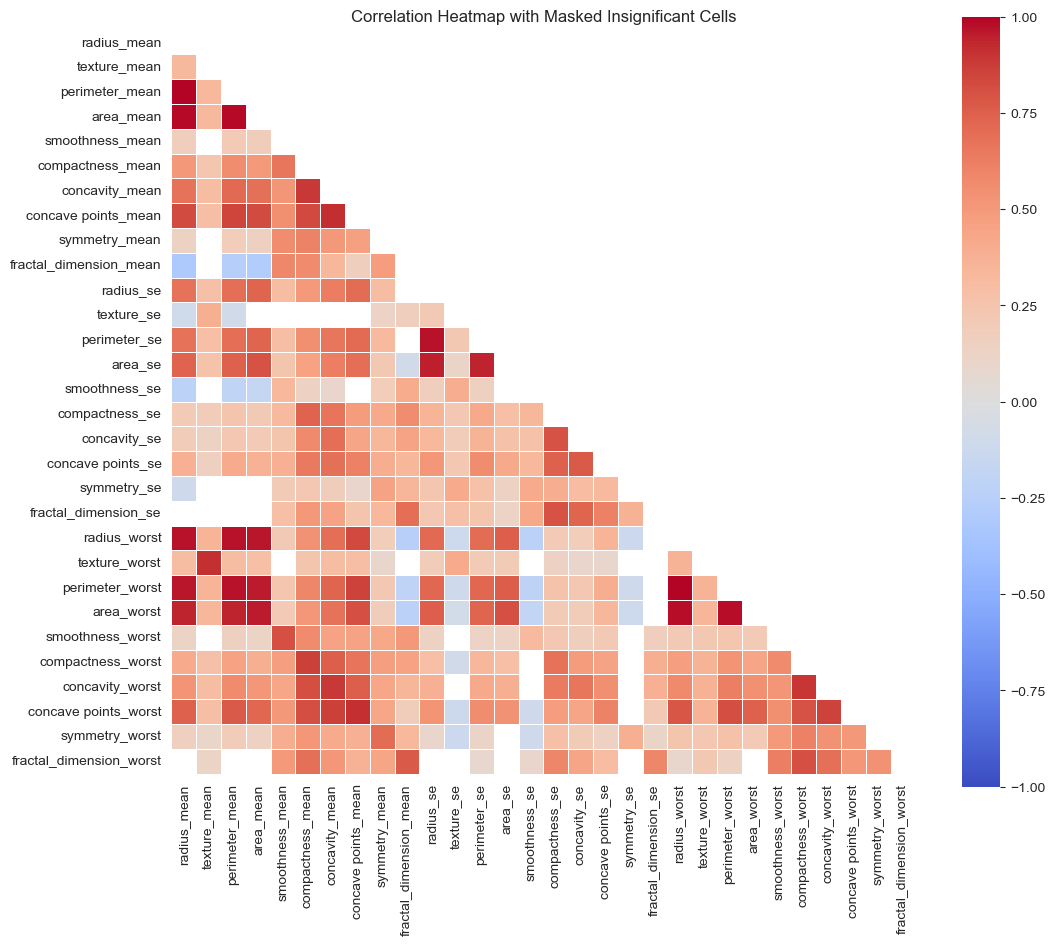

In [14]:
binary_df, corr_matrix = calculate_pearson_and_significance(df, columns = mean_columns + se_columns + worst_columns)

visualize_correlation_heatmap(corr_matrix, binary_df)
# Why annot not displaying?

**Note:** Could make an effort to address collinearity but not going to at this time. 06/07/24

In [15]:
def print_non_significant_relationships(binary_df):
    """
    Prints the row and column names of non-significant relationships.
    
    Parameters:
    binary_df (pd.DataFrame): Binary DataFrame indicating significance of correlation coefficients.
    """
    # Iterate through the DataFrame
    for i, row in binary_df.iterrows():
        # Check if all values in the row are equal to 1 (indicating significance)
        if (row == 1).all():
            print(f"None for '{i}'")
        else:
            print(i)
            # Initialize a set to keep track of processed relationships
            processed_relationships = set()
            # Iterate through the row and print column names where the value is 0
            for j, value in row.items():
                # Check if the relationship is not between the same variable (n, n)
                if i != j:
                    # Check if the relationship has not been processed and the value is 0
                    if (i, j) not in processed_relationships and (j, i) not in processed_relationships and value == 0:
                        print(f"Non-significant relationship between '{i}' and '{j}'")
                        # Add the relationship to the processed set
                        processed_relationships.add((i, j))
            print()

# print_non_significant_relationships(binary_df)

In [16]:
def calculate_pointbiserial_and_significance(dataframe, binary_col, cont_col, alpha = 0.05):
    # Iniit list for results
    results = []

    for col in cont_col:
        filtered_df = dataframe[[binary_col, col]].dropna()

        binary_data = filtered_df[binary_col]
        cont_data = filtered_df[col]

        # Checking appropriate amount of datapoints for calculations:
        if len(binary_data) > 1 and len(cont_data) > 1:
            corr, p_value = pointbiserialr(binary_data, cont_data)
    
            # Is result sig?
            signif = 'Yes' if p_value < alpha else 'No'
    
        else:
            corr, p_value, signif = None, None, 'Not enough data'

        results.append({'Feature': col
                        ,'Correlation': corr
                        ,'p_Value': p_value
                        ,'Significant': signif
                       })

    results_df = pd.DataFrame(results)

    return results_df    

In [17]:
corr_df = calculate_pointbiserial_and_significance(df, binary_col='diagnosis', cont_col=mean_columns)
corr_df

,Feature,Correlation,p_Value,Significant
0,radius_mean,0.730029,8.465941e-96,Yes
1,texture_mean,0.415185,4.058636e-25,Yes
2,perimeter_mean,0.742636,8.436251e-101,Yes
3,area_mean,0.708984,4.734564e-88,Yes
4,smoothness_mean,0.358560,1.051850e-18,Yes
5,compactness_mean,0.596534,3.938263e-56,Yes
6,concavity_mean,0.696360,9.966556e-84,Yes
7,concave points_mean,0.776614,7.101150e-116,Yes
8,symmetry_mean,0.330499,5.733384e-16,Yes
9,fractal_dimension_mean,-0.012838,7.599368e-01,No


In [18]:
def visualize_singlecol_corr_heatmap(corr_dataframe, outcome):
    sorted_df = corr_dataframe.sort_values(by = 'Correlation'
                                           ,ascending = False)

    heatmap_data = sorted_df.set_index('Feature')

    # Setting up figure
    plt.figure(figsize = (8, 10))
    plt.title(f"Features' Correlation to {outcome}")

    sns.heatmap(heatmap_data[['Correlation']]
                ,vmin = -1
                ,vmax = 1
                ,cmap = 'coolwarm'
                ,annot = True
                ,annot_kws = {'fontsize': 10}
                ,fmt = ".2f"
                # ,square = True
                ,linewidths = .5)

    # Adding hatching to non-sig cells
    for y in range(heatmap_data.shape[0]):
        if heatmap_data['Significant'].iloc[y] == 'No':
            plt.gca().add_patch(plt.Rectangle((0, y), 1, 1, fill = False, hatch = 'x', edgecolor = 'yellow', lw = 1))

    return

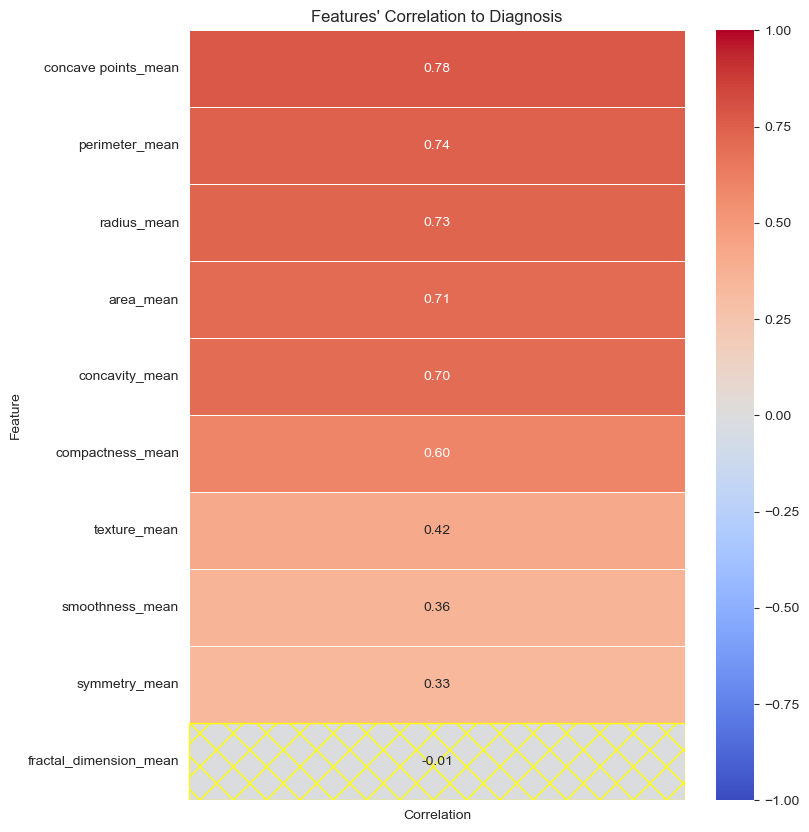

In [19]:
visualize_singlecol_corr_heatmap(corr_df, 'Diagnosis')

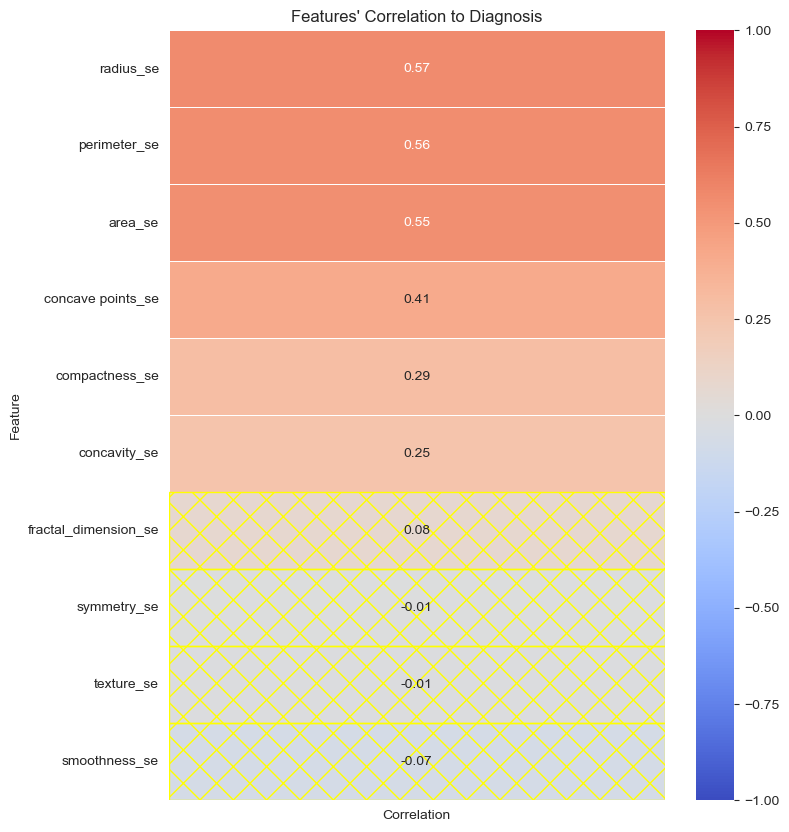

In [20]:
corr_df = calculate_pointbiserial_and_significance(df, binary_col='diagnosis', cont_col=se_columns)
visualize_singlecol_corr_heatmap(corr_df, 'Diagnosis')

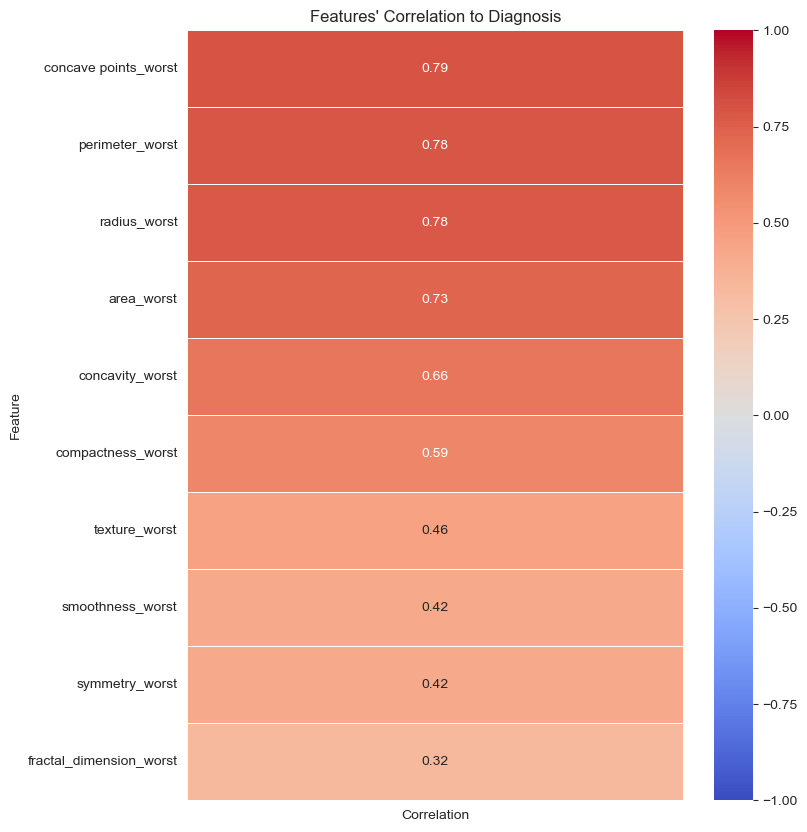

In [21]:
corr_df = calculate_pointbiserial_and_significance(df, binary_col='diagnosis', cont_col=worst_columns)
visualize_singlecol_corr_heatmap(corr_df, 'Diagnosis')

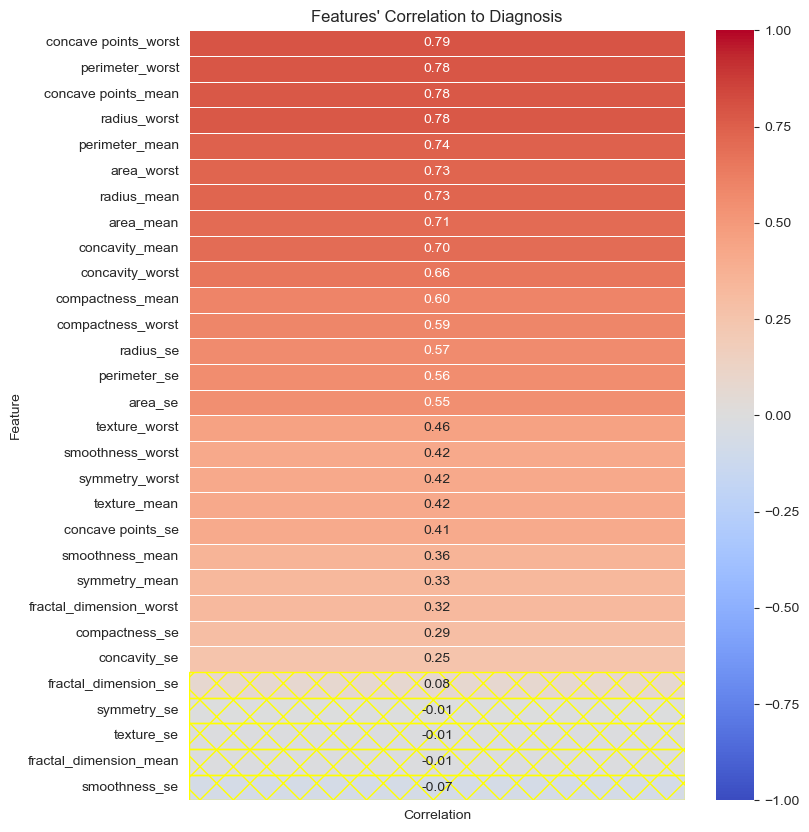

In [22]:
corr_df = calculate_pointbiserial_and_significance(df, binary_col='diagnosis', cont_col=mean_columns + se_columns + worst_columns)
visualize_singlecol_corr_heatmap(corr_df, 'Diagnosis')

As determined by the Point Biserial correlation coefficients, the following features have no (significant) relationship to 'diagnosis':
| Feature | Correlation Coef. |
| -------- | ------- |
| fractal_dimension_se | 0.08 |
| symmetry_se | -0.01 |
| texture_se | -0.01 |
| fractal_dimension_mean | -0.01 |
| smoothness_se | -0.07 |

All other features have a positive relationship with 'diagnosis', indicating that as the features' value increase, so does the likelihood of a malignant diagnosis (1).

Those features with the strongest relationships include:
| Feature | Correlation Coef. |
| -------- | ------- |
| concave points_worst | 0.79 |
| perimeter_worst | 0.78 |
| concave points_mean | 0.78 |
| radius_worst | 0.78 |
| perimeter_mean | 0.74 |

#### T-Tests
To observe the relationships between features and the binary outcome 'diagnosis'

In [23]:
def calculate_t_test(dataframe, binary_col, cont_col, alpha = 0.05):
    # Init list for results
    results = []

    for col in cont_col:
        filtered_df = dataframe[[binary_col, col]].dropna()

        group0 = filtered_df[filtered_df[binary_col] == 0][col]
        group1 = filtered_df[filtered_df[binary_col] == 1][col]

        # Calculating means:
        mean0 = group0.mean() if len(group0) > 0 else None
        mean1 = group1.mean() if len(group1) > 0 else None

        # T-Tests
        if len(group0) > 1 and len(group1) > 1:
            t_stat, p_value = ttest_ind(group0, group1)

            # Significant?
            signif = 'Yes' if p_value < alpha else 'No'

        else:
            # Setting None if calculation not possible
            t_stat, p_value, signif = None, None, 'Not enough data'


        diff_means = (mean1 - mean0) if (mean0 is not None and mean1 is not None) else None
        
        # Appending results to list, to build results' dataframe
        results.append({'Feature': col
                        ,'T-statistic': t_stat
                        ,'p_Value': p_value
                        ,'Significant': signif
                        ,'Total Observations': len(filtered_df)
                        ,'Benign Observations': len(group0)
                        ,'Malignant Observations': len(group1)
                        ,'Benign Mean': mean0
                        ,'Malignant Mean': mean1
                        ,'Difference Between Means': diff_means
                       })

    results_df = pd.DataFrame(results)

    return results_df    

In [24]:
calculate_t_test(df, 'diagnosis', mean_columns).sort_values(by = ['T-statistic', 'Difference Between Means'])

,Feature,T-statistic,p_Value,Significant,Total Observations,Benign Observations,Malignant Observations,Benign Mean,Malignant Mean,Difference Between Means
7,concave points_mean,-29.354319,7.101150e-116,Yes,569,357,212,0.025717,0.087990,0.062273
2,perimeter_mean,-26.405213,8.436251e-101,Yes,569,357,212,78.075406,115.365377,37.289971
0,radius_mean,-25.435822,8.465941e-96,Yes,569,357,212,12.146524,17.462830,5.316306
3,area_mean,-23.938687,4.734564e-88,Yes,569,357,212,462.790196,978.376415,515.586219
6,concavity_mean,-23.103963,9.966556e-84,Yes,569,357,212,0.046058,0.160775,0.114717
5,compactness_mean,-17.698392,3.938263e-56,Yes,569,357,212,0.080085,0.145188,0.065103
1,texture_mean,-10.867201,4.058636e-25,Yes,569,357,212,17.914762,21.604906,3.690144
4,smoothness_mean,-9.146099,1.051850e-18,Yes,569,357,212,0.092478,0.102898,0.010421
8,symmetry_mean,-8.338312,5.733384e-16,Yes,569,357,212,0.174186,0.192909,0.018723
9,fractal_dimension_mean,0.305711,7.599368e-01,No,569,357,212,0.062867,0.062680,-0.000187


In [25]:
calculate_t_test(df, 'diagnosis', se_columns).sort_values(by = ['T-statistic', 'Difference Between Means'])

,Feature,T-statistic,p_Value,Significant,Total Observations,Benign Observations,Malignant Observations,Benign Mean,Malignant Mean,Difference Between Means
0,radius_se,-16.396351,9.738949e-50,Yes,569,357,212,0.284082,0.609083,0.325000
2,perimeter_se,-15.934158,1.651905e-47,Yes,569,357,212,2.000321,4.323929,2.323608
3,area_se,-15.609343,5.895521e-46,Yes,569,357,212,21.135148,72.672406,51.537257
7,concave points_se,-10.642498,3.072309e-24,Yes,569,357,212,0.009858,0.015060,0.005203
5,compactness_se,-7.297077,9.975995e-13,Yes,569,357,212,0.021438,0.032281,0.010843
6,concavity_se,-6.246157,8.260176e-10,Yes,569,357,212,0.025997,0.041824,0.015827
9,fractal_dimension_se,-1.862330,6.307355e-02,No,569,357,212,0.003636,0.004062,0.000426
8,symmetry_se,0.155298,8.766418e-01,No,569,357,212,0.020584,0.020472,-0.000111
1,texture_se,0.197724,8.433320e-01,No,569,357,212,1.220380,1.210915,-0.009465
4,smoothness_se,1.599365,1.102966e-01,No,569,357,212,0.007196,0.006780,-0.000416


In [26]:
calculate_t_test(df, 'diagnosis', worst_columns).sort_values(by = ['T-statistic', 'Difference Between Means'])

,Feature,T-statistic,p_Value,Significant,Total Observations,Benign Observations,Malignant Observations,Benign Mean,Malignant Mean,Difference Between Means
7,concave points_worst,-31.054555,1.969100e-124,Yes,569,357,212,0.074444,0.182237,0.107793
2,perimeter_worst,-29.965717,5.771397e-119,Yes,569,357,212,87.005938,141.370330,54.364392
0,radius_worst,-29.339082,8.482292e-116,Yes,569,357,212,13.379801,21.134811,7.755010
3,area_worst,-25.721590,2.828848e-97,Yes,569,357,212,558.899440,1422.286321,863.386881
6,concavity_worst,-20.897175,2.464664e-72,Yes,569,357,212,0.166238,0.450606,0.284368
5,compactness_worst,-17.445374,7.069816e-55,Yes,569,357,212,0.182673,0.374824,0.192152
1,texture_worst,-12.230981,1.078057e-30,Yes,569,357,212,23.515070,29.318208,5.803138
4,smoothness_worst,-11.066747,6.575144e-26,Yes,569,357,212,0.124959,0.144845,0.019886
8,symmetry_worst,-10.902304,2.951121e-25,Yes,569,357,212,0.270246,0.323468,0.053222
9,fractal_dimension_worst,-8.151316,2.316432e-15,Yes,569,357,212,0.079442,0.091530,0.012088


In [27]:
calculate_t_test(df, 'diagnosis', mean_columns + se_columns + worst_columns).sort_values(by = ['T-statistic', 'Difference Between Means'])

,Feature,T-statistic,p_Value,Significant,Total Observations,Benign Observations,Malignant Observations,Benign Mean,Malignant Mean,Difference Between Means
27,concave points_worst,-31.054555,1.969100e-124,Yes,569,357,212,0.074444,0.182237,0.107793
22,perimeter_worst,-29.965717,5.771397e-119,Yes,569,357,212,87.005938,141.370330,54.364392
7,concave points_mean,-29.354319,7.101150e-116,Yes,569,357,212,0.025717,0.087990,0.062273
20,radius_worst,-29.339082,8.482292e-116,Yes,569,357,212,13.379801,21.134811,7.755010
2,perimeter_mean,-26.405213,8.436251e-101,Yes,569,357,212,78.075406,115.365377,37.289971
23,area_worst,-25.721590,2.828848e-97,Yes,569,357,212,558.899440,1422.286321,863.386881
0,radius_mean,-25.435822,8.465941e-96,Yes,569,357,212,12.146524,17.462830,5.316306
3,area_mean,-23.938687,4.734564e-88,Yes,569,357,212,462.790196,978.376415,515.586219
6,concavity_mean,-23.103963,9.966556e-84,Yes,569,357,212,0.046058,0.160775,0.114717
26,concavity_worst,-20.897175,2.464664e-72,Yes,569,357,212,0.166238,0.450606,0.284368


Continuing on from correlation coefficients, the results of the t-test further explore the differences between 'diagnosis' groups Benign and Malignant.

The following features have no (significant) differences in means when stratified by 'diagnosis':
| Feature | T-Stat | Difference in Means |
| -------- | ------- | ------- |
| fractal_dimension_se | -1.862330 | 0.000426 |
| symmetry_se | 0.155298| -0.000111 |
| texture_se | 0.197724| -0.009465 |
| fractal_dimension_mean | 0.305711 | -0.000187 |
| smoothness_se | 1.599365 | -0.000416 |

All other features have a relationship with 'diagnosis', where the means of Malignant group and higher than the means of Benign group.

Those features with the strongest relationships include:
| Feature | T-Stat | Difference in Means |
| -------- | ------- | ------- |
| concave points_worst | -31.054555 | 0.107793 |
| perimeter_worst | -29.965717 | 54.364392 |
| concave points_mean | -29.354319 | 0.062273 |
| radius_worst | -29.339082 | 7.755010 |
| perimeter_mean | -26.405213 | 37.289971 |


## Modeling

In [28]:
print(df['diagnosis'].value_counts())
print()
print(df['diagnosis'].value_counts(normalize = True))

diagnosis
0    357
1    212
Name: count, dtype: int64

diagnosis
0    0.627417
1    0.372583
Name: proportion, dtype: float64


Our population's outcome (diagnosis) is split:
- 63% Benign (0)
- 37% Malignant (1)

### Feature Preparation
As demonstrated with both correlation coefficients and independent t-tests, the following features have no relationship to our outcome (diagnosis). They will be dropped from modeling:
- fractal_dimension_se
- symmetry_se
- texture_se
- fractal_dimension_mean
- smoothness_se

In [29]:
df.drop(columns = ['fractal_dimension_se', 'symmetry_se'
                   ,'texture_se', 'fractal_dimension_mean'
                   ,'smoothness_se']
        ,inplace = True)

In [30]:
len(df.columns)

27

### Single Feature Logistic Regression

In [31]:
def single_feature_logistic_regression(df, target_col, feature_cols, plot=True):
    results = []

    for feature in feature_cols:
        X = df[[feature]]
        y = df[target_col]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = LogisticRegression()
        model.fit(X_train, y_train)

        # Predict probabilities for testing set
        y_prob = model.predict_proba(X_test)
        
        # Get coefficient and intercept
        coef = model.coef_[0][0]
        intercept = model.intercept_[0]

        # Calculate odds ratio
        odds_ratio = np.exp(coef)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        results.append({'Feature': feature, 'Accuracy': accuracy,
                        'Coefficient': coef, 'Intercept': intercept,
                        'Odds Ratio': odds_ratio})

        # Plot the predicted probabilities for testing data along with actual class labels if plot is True
        if plot:
            plt.rcParams.update({'font.size': 8})
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=X_test.iloc[:, 0], y=y_prob[:, 1], hue=y_test)
            plt.xlabel(feature)
            plt.ylabel('Probability of Malignancy')
            plt.ylim(-0.10, 1.10)
            plt.title(f'Logistic Regression Predictions - {feature}\nAccuracy: {round(accuracy, 4)}')
            legend =  plt.legend(title='Actual Diagnosis', loc='upper left', fontsize = 8)
            plt.setp(legend.get_title(), fontsize=8)
            plt.show()


    return pd.DataFrame(results)


# Example usage:
# Assuming df is your DataFrame with 'diagnosis' as the target column and other features as feature columns
target_col = 'diagnosis'  # Target column name
features = df.drop(columns = ['id', 'diagnosis']).columns
results_df = single_feature_logistic_regression(df, target_col, features, plot = False)

In [32]:
results_df[results_df['Accuracy'] >= 0.90].sort_values(by = 'Accuracy', ascending = False)

,Feature,Accuracy,Coefficient,Intercept,Odds Ratio
17,perimeter_worst,0.964912,0.161997,-17.862242,1.175856
15,radius_worst,0.938596,1.054382,-17.565511,2.870199
18,area_worst,0.938596,0.010865,-9.285249,1.010924
2,perimeter_mean,0.929825,0.151145,-14.526079,1.163165
3,area_mean,0.921053,0.010872,-7.414512,1.010931
11,area_se,0.921053,0.123675,-4.540850,1.131648
0,radius_mean,0.912281,0.948621,-14.036740,2.582146


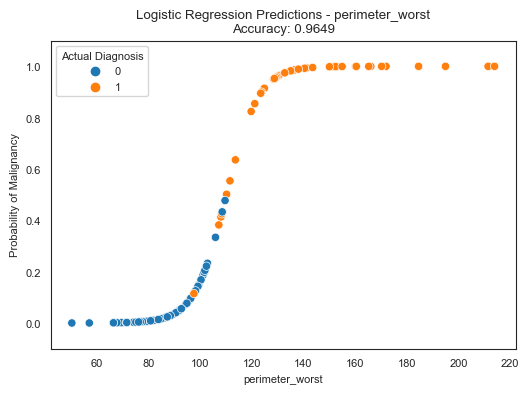

In [33]:
temp = results_df[results_df['Accuracy'] >= 0.95].sort_values(by = 'Accuracy', ascending = False)['Feature']

results_df_refined = single_feature_logistic_regression(df, target_col, temp)

### Multivariate Logistic Regression

In [34]:
def fit_lasso_logistic_regression(df, target_col, feature_cols, alpha=1.0, scale_features=True):
    """
    Fits a Lasso logistic regression model on the given DataFrame.

    Parameters:
        df (DataFrame): The input DataFrame.
        target_col (str): The name of the target column.
        feature_cols (list of str): The list of feature column names.
        alpha (float): Regularization strength. Lower values specify stronger regularization.
        scale_features (bool): Whether to scale features before fitting the model.

    Returns:
        Tuple: A tuple containing X_train, X_test, y_train, y_test, and a dictionary of results.
    """
    X = df[feature_cols]
    y = df[target_col]

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    if scale_features:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test

    model = LogisticRegression(penalty='l1', solver='liblinear', C=alpha)
    model.fit(X_train_scaled, y_train)

    # Calculate probability scores and predicted labels for the test set
    y_score = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model's performance on the training set
    train_accuracy = model.score(X_train_scaled, y_train)

    # Evaluate the model's performance on the testing set
    test_accuracy = model.score(X_test_scaled, y_test)

    res_dict = {
        'features': feature_cols,
        'coefficients': model.coef_[0],
        'intercept': model.intercept_[0],
        'training_accuracy': train_accuracy,
        'testing_accuracy': test_accuracy,
        'y_score': y_score,
        'y_pred': y_pred
    }

    return X_train, X_test, y_train, y_test, res_dict

# Example usage:
# Assuming df is your DataFrame with 'diagnosis' as the target column and other features as feature columns
target_col = 'diagnosis'  # Target column name
features = df.drop(columns = ['id', 'diagnosis']).columns
X_train, X_test, y_train, y_test, lasso_results = fit_lasso_logistic_regression(df, target_col,features)

In [35]:
accuracy = accuracy_score(y_test, lasso_results['y_pred'])
accuracy

0.972027972027972

In [36]:
lasso_results['training_accuracy'], lasso_results['testing_accuracy']

(0.9835680751173709, 0.972027972027972)

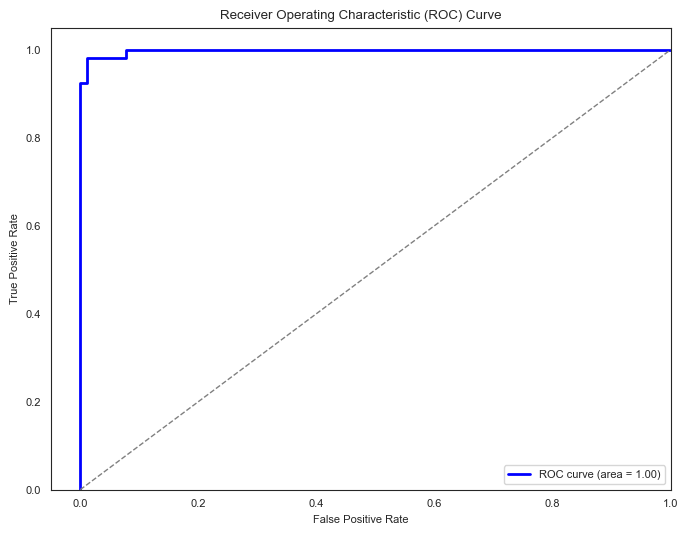

In [37]:
def plot_roc_curve(y_test, y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Example usage:
# Assuming lasso_results is the dictionary returned by fit_lasso_logistic_regression
plot_roc_curve(y_test, lasso_results['y_score'])

In [38]:
#Classification Report
report = classification_report(y_test, lasso_results['y_pred'])
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        90
           1       0.98      0.94      0.96        53

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



<Figure size 800x600 with 0 Axes>

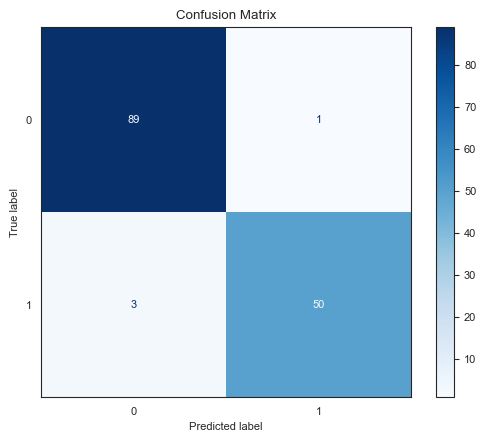

In [39]:
def visualize_confusion_matrix(y_true, y_pred):
    sns.set_style("white")

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    plt.figure(figsize=(8, 6))
    
    disp.plot(cmap=plt.cm.Blues)
    
    plt.title('Confusion Matrix')
    plt.show()
    return

# Example usage:
# Assuming lasso_results is the dictionary returned by fit_lasso_logistic_regression
visualize_confusion_matrix(y_test, lasso_results['y_pred'])

In [40]:
def plot_odds_ratios(coefficients, feature_names):
    # Calculate odds ratios
    odds_ratios = np.exp(coefficients)

    # Round the odds ratios to two decimal places
    rounded_odds_ratios = [round(x, 2) for x in odds_ratios]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 8))
    rects = ax.barh(feature_names, odds_ratios)

    # Bar labels
    for rect, label in zip(rects, rounded_odds_ratios):
        width = rect.get_width()
        ax.text(width, rect.get_y() + rect.get_height() / 2, f'{label}', ha='left', va='center', color='grey', fontsize=8)

    # Add a red dashed vertical line at 1
    ax.axvline(x=1, color='red', linestyle='--')
    
    ax.set_xlabel('Odds Ratio')
    ax.set_ylabel('Features')
    ax.set_title('Feature Importance (Odds Ratios)')

    plt.gca().invert_yaxis()
    plt.show()

    return

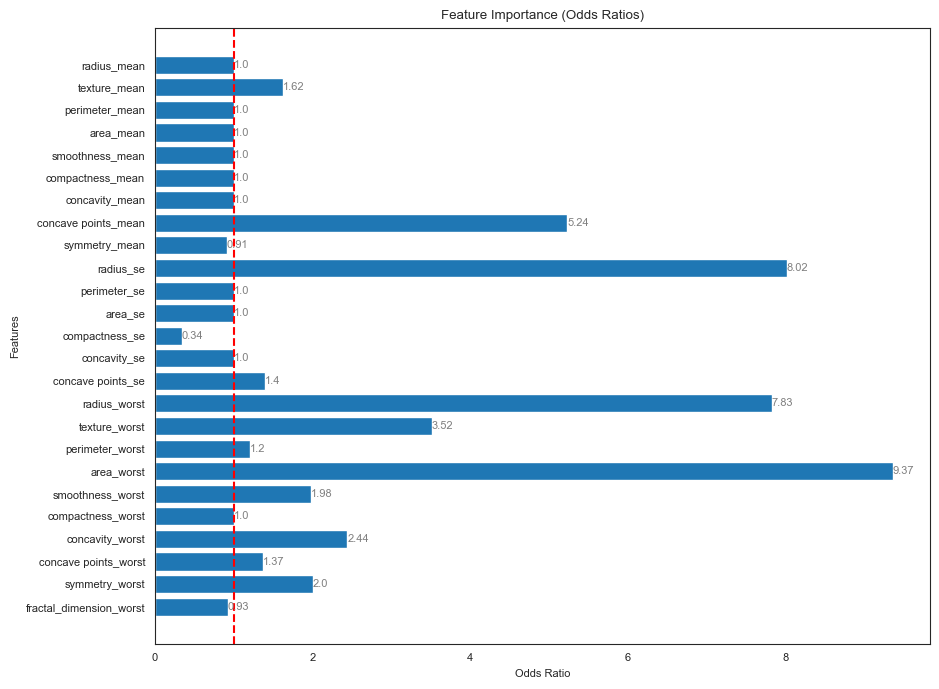

In [41]:
coefficients = lasso_results['coefficients']
feature_names = lasso_results['features']

# Plot odds ratios
plot_odds_ratios(coefficients, feature_names)

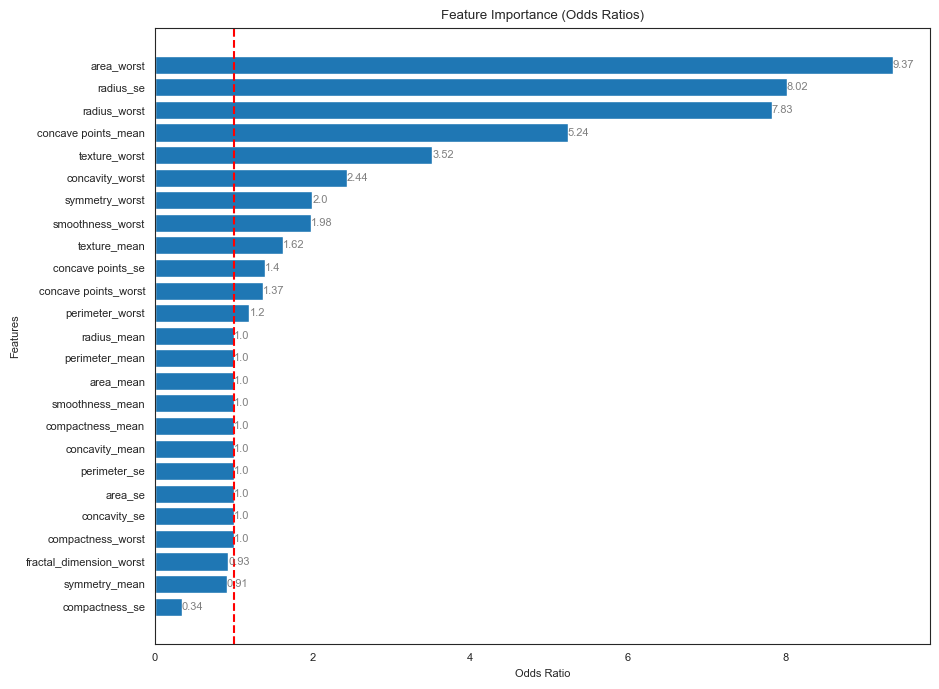

In [42]:
def plot_odds_ratios(coefficients, feature_names):
    # Calculate odds ratios
    odds_ratios = np.exp(coefficients)

    # Round the odds ratios to two decimal places
    rounded_odds_ratios = [round(x, 2) for x in odds_ratios]

    # Sort feature names and odds ratios based on odds ratios
    sorted_data = sorted(zip(feature_names, rounded_odds_ratios), key=lambda x: x[1], reverse=True)
    sorted_feature_names, sorted_rounded_odds_ratios = zip(*sorted_data)

    # # Create colormap with proper normalization
    # norm = LogNorm(vmin=min(sorted_rounded_odds_ratios), vmax=max(sorted_rounded_odds_ratios))
    # cmap = cm.coolwarm

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 8))
    rects = ax.barh(sorted_feature_names, sorted_rounded_odds_ratios)

    # Bar labels
    for rect, label in zip(rects, sorted_rounded_odds_ratios):
        width = rect.get_width()
        ax.text(width, rect.get_y() + rect.get_height() / 2, f'{label}', ha='left', va='center', color='grey', fontsize=8)

    # Add a red dashed vertical line at 1
    ax.axvline(x=1, color='red', linestyle='--')
    
    ax.set_xlabel('Odds Ratio')
    ax.set_ylabel('Features')
    ax.set_title('Feature Importance (Odds Ratios)')

    plt.gca().invert_yaxis()
    plt.show()

    return


coefficients = lasso_results['coefficients']
feature_names = lasso_results['features']

# Plot odds ratios
plot_odds_ratios(coefficients, feature_names)

In [43]:
features = lasso_results['features']
coefficients = lasso_results['coefficients']

# Create a DataFrame
df_coeffs = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Filter out instances where coefficient == 0
df_filtered = df_coeffs[df_coeffs['Coefficient'] != 0]

# Get the features after filtering
filtered_features = df_filtered['Feature'].values

In [44]:
filtered_features

array(['texture_mean', 'concave points_mean', 'symmetry_mean',
       'radius_se', 'compactness_se', 'concave points_se', 'radius_worst',
       'texture_worst', 'perimeter_worst', 'area_worst',
       'smoothness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'], dtype=object)

In [45]:
X_train, X_test, y_train, y_test, lasso_results_filtered = fit_lasso_logistic_regression(df, target_col, filtered_features)

In [46]:
lasso_results_filtered['training_accuracy'], lasso_results_filtered['testing_accuracy']

(0.9835680751173709, 0.972027972027972)

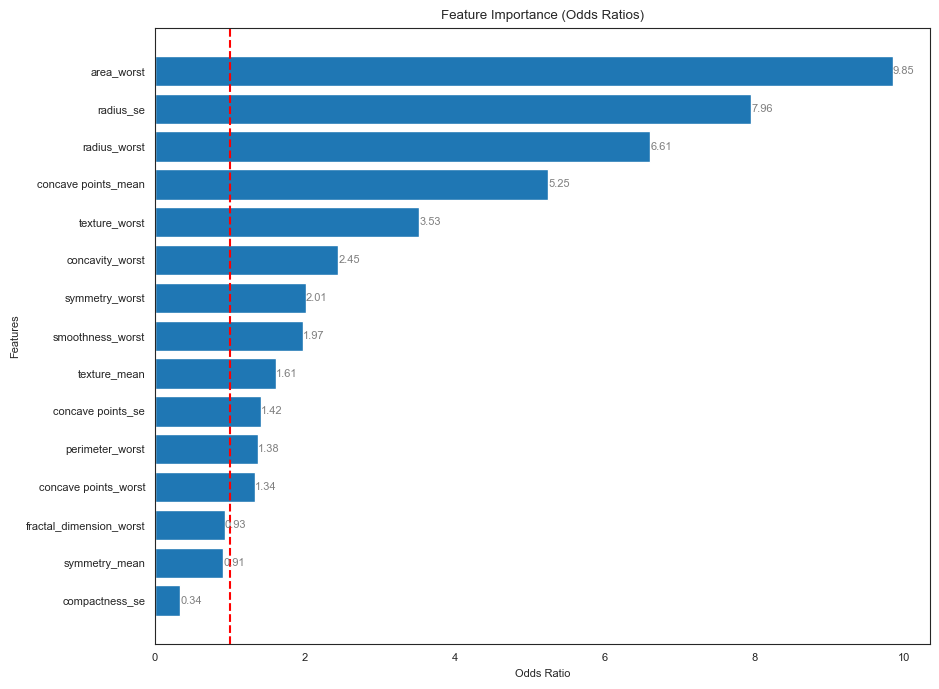

In [47]:
coefficients = lasso_results_filtered['coefficients']
feature_names = lasso_results_filtered['features']

plot_odds_ratios(coefficients, feature_names)

In using LASSO regularization, we can identify 15 of the original 32 relevant features needed to make an accurate prediction of a tumor's malignancy (with 97% accuracy)